# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#Obtain)**<br>
- **[SCRUB](#Scrub)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# Introduction

## Business Statement

One of the primary roles of a realtor is to provide their clients with a good initial estimate for a listing price. The listing price can't be too high, or else it may scare off potential buyers, and the price cannot be too low because then the home seller will sacrifice potential profit. Therefore, if a model can be built which predicts the appropriate listing price, a home seller can be confident that they will sell their house at a favorable price.

## Analysis Methodology

I will be analyzing historic home sales from King County, Washington in order to see which factors affect home price and how a model can be built to predict good estimates for home listing prices.

# Obtain

## Import Packages

In [718]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [613]:
pd.set_option("display.max_columns", 25)
pd.options.display.float_format = '{:,}'.format

## Global Functions

In [701]:
#function to look at histogram and scatter plot of column
def get_plots(df, x_col, y_col='price'):
    
    """This function takes in a dataframe and a column, removes outliers beyond
       3 standard deviations and produces a histogram, scatter plot of the 
       values and descriptive statistics"""
    col_mean = df[x_col].mean()
    col_std = df[x_col].std()
    upper_thresh = col_mean + 3*col_std
    lower_thresh = col_mean - 3*col_std
    new_df = df.loc[(df[x_col] > lower_thresh) & (df[x_col] < upper_thresh)]
    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    histogram = new_df[x_col].hist(ax=ax[0]);
    ax[0].set_title(f'Distribution of {x_col}');
    scatter = new_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[1])
    ax[1].set_title(f'{y_col} vs {x_col}');
    stats = new_df[x_col].describe()
    return histogram, scatter, stats

In [698]:
mean = df_scrub['price'].mean()
std = df_scrub['price'].std()
upper_thresh = mean + 2*std
lower_thresh = mean - 2*std
new_df = df_scrub.loc[(df_scrub['price'] < upper_thresh) &]
new_df.sort_values('price', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
8467,4139490210,2014-07-30,"1,290,000.0",4,3.5,4080,14450,2.0,0.0,3,12,3210,1998,0.0,98006,47.5519,-122.10600000000001,1,7,0,2014,16
17232,4141010050,2015-01-21,"1,290,000.0",3,2.5,3240,12625,2.0,0.0,3,11,3240,1987,0.0,98040,47.5327,-122.23200000000001,0,1,0,2015,28
16185,4218400005,2015-01-30,"1,290,000.0",3,2.25,2440,9200,1.0,0.0,4,8,2440,1950,0.0,98105,47.6629,-122.26899999999999,0,1,0,2015,65
12413,904000045,2014-06-23,"1,290,000.0",3,2.5,2190,11394,1.0,0.0,3,8,1550,1956,0.0,98199,47.6685,-122.40899999999999,1,6,0,2014,58
14202,8156600210,2015-03-26,"1,290,000.0",5,3.5,2980,5100,2.0,0.0,3,10,2370,2015,0.0,98115,47.6782,-122.29899999999999,1,3,0,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16700,1322049150,2015-03-05,"85,000.0",2,1.0,910,9753,1.0,0.0,3,5,910,1947,0.0,98032,47.3897,-122.236,0,3,0,2015,68
3763,1523049188,2015-04-30,"84,000.0",2,1.0,700,20130,1.0,0.0,3,6,700,1949,0.0,98168,47.4752,-122.271,0,4,0,2015,66
18453,7999600180,2014-05-29,"83,000.0",2,1.0,900,8580,1.0,0.0,3,5,900,1918,0.0,98168,47.4727,-122.27,0,5,0,2014,96
2139,1623049041,2014-05-08,"82,500.0",2,1.0,520,22334,1.0,0.0,2,5,520,1951,0.0,98168,47.4799,-122.296,0,5,0,2014,63


## Import Data into Pandas

I will be importing a csv dataset which provides me with the information necessary to begin the analysis.

In [615]:
#import the dataset from local csv
df_original = pd.read_csv('Data/kc_house_data.csv')
df_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Investigate Data

I will preliminarily investigate the data to identify any glaring issues to fix later.

In [616]:
#column names
df_original.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [617]:
#view df info to inspect data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Observations on Data**
> - `waterfront` values should be updated to categorical
> - `yr_renovated` values should be updated to categorical
> - `sqft_basement` data type should be changed to integer

In [618]:
#check for null values
df_original.isna().sum()/len(df_original)*100

id                              0.0
date                            0.0
price                           0.0
bedrooms                        0.0
bathrooms                       0.0
sqft_living                     0.0
sqft_lot                        0.0
floors                          0.0
waterfront        11.00152798999861
view            0.29170718155299347
condition                       0.0
grade                           0.0
sqft_above                      0.0
sqft_basement                   0.0
yr_built                        0.0
yr_renovated      17.78950780200954
zipcode                         0.0
lat                             0.0
long                            0.0
sqft_living15                   0.0
sqft_lot15                      0.0
dtype: float64

> **Observations on Data**
> - `waterfront` has 11% null values which may be dropped
> - `view` should be inspected for a potential column drop
> - `yr_renovated` has 18% null values which may be dropped
> - All other columns have 0 nulls

In [619]:
#check numeric data
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","19,221.0","21,534.0","21,597.0","21,597.0","21,597.0","21,597.0","17,755.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0"
mean,"4,580,474,287.770987","540,296.5735055795",3.3731999814789093,2.1158262721674306,"2,080.3218502569803","15,099.408760475992",1.4940964022780943,0.007595858696217679,0.23386272870808952,3.4098254387183404,7.657915451220076,"1,788.5968421540028","1,970.9996758809093",83.6367783722895,"98,077.95184516368",47.56009299439737,-122.2139824975691,"1,986.6203176367087","12,758.283511598833"
std,"2,876,735,715.74778","367,368.1401013945",0.9262988945421479,0.7689842966527209,918.1061250800805,"41,412.636875502074",0.5396827909775457,0.08682484570054606,0.7656862011746727,0.6505456356725546,1.1731996637760254,827.7597611646754,29.375234132441644,399.9464138788162,53.51307235352816,0.13855176817307177,0.14072352882947373,685.2304719001586,"27,274.441950386343"
min,"1,000,102.0","78,000.0",1.0,0.5,370.0,520.0,1.0,0.0,0.0,1.0,3.0,370.0,"1,900.0",0.0,"98,001.0",47.1559,-122.51899999999999,399.0,651.0
25%,"2,123,049,175.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,"1,190.0","1,951.0",0.0,"98,033.0",47.4711,-122.32799999999999,"1,490.0","5,100.0"
50%,"3,904,930,410.0","450,000.0",3.0,2.25,"1,910.0","7,618.0",1.5,0.0,0.0,3.0,7.0,"1,560.0","1,975.0",0.0,"98,065.0",47.5718,-122.23100000000001,"1,840.0","7,620.0"
75%,"7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,685.0",2.0,0.0,0.0,4.0,8.0,"2,210.0","1,997.0",0.0,"98,118.0",47.678000000000004,-122.125,"2,360.0","10,083.0"
max,"9,900,000,190.0","7,700,000.0",33.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,"9,410.0","2,015.0","2,015.0","98,199.0",47.7776,-121.315,"6,210.0","871,200.0"


# Scrub

I will make a new dataframe which is a copy of the `df_original` dataframe to begin making changes. 

In [620]:
#create a copy of the original dataframe
df_scrub = df_original.copy()
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Create New Columns

### Basement Column

In the dataset we have 3 related columns:
- `sqft_above`
- `sqft_basement`
- `sqft_living`

These columns are related in that `sqft_living` equals `sqft_above` plus `sqft_basement`. I do not think the square footage of the basement is as important as just knowing that a house has one. Therefore, I will create a new column which shows whether or not a house has a basement.

In [621]:
#investigate values in sqft_basement
df_scrub['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2730.0        1
4130.0        1
906.0         1
2240.0        1
556.0         1
Name: sqft_basement, Length: 304, dtype: int64

> **ACTION: '?' impedes the ability to create a new column. Will drop the 454 rows, which is 2% of the data**

In [622]:
#drop rows with '?' value in sqft_basement column
df_scrub.drop(df_scrub.loc[df_scrub['sqft_basement'] == '?'].index,inplace=True)
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 21143 many rows.


In [623]:
#prove that these columns are related
df_scrub['sqft_basement'] = df_scrub['sqft_basement'].astype(float).astype(int)
sqft = df_scrub[['sqft_living', 'sqft_above', 'sqft_basement']]
df_scrub['sqft_basement'].dtype
(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']).value_counts()

True    21143
dtype: int64

In [624]:
#check the rows have been dropped
df_scrub.loc[df_original['sqft_basement'] == '?']['sqft_basement'].count()

0

In [625]:
#create new column for basement
df_scrub['basement'] = np.where(df_scrub['sqft_basement'] > 0, 1,0)
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639,1
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062,0
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000,1
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509,0
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200,0
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007,0
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287,0


### Month Sold Column

I want to extract the month sold to investigate if sale timing has any affect on housing prices

In [626]:
#create new month sold column
df_scrub['date'] = pd.to_datetime(df_scrub['date'])
df_scrub['month_sold'] = df_scrub['date'].dt.month
df_scrub.loc[:3,['date','month_sold']]

,date,month_sold
0,2014-10-13,10
1,2014-12-09,12
2,2015-02-25,2
3,2014-12-09,12


### Renovated Column

I want to reconfigure the `yr_renovated` column so that it is compatible with the model. I will drop null rows and create a new column which indicates whether or not a house has been renovated.

In [627]:
#check values in yr_renovated column
df_scrub['yr_renovated'].value_counts(dropna=False).head(20)

0.0        16666
nan         3754
2,014.0       69
2,013.0       31
2,003.0       31
2,007.0       30
2,000.0       29
2,005.0       29
1,990.0       22
2,009.0       21
2,004.0       21
2,006.0       20
1,989.0       18
2,002.0       17
2,008.0       15
1,998.0       15
1,999.0       15
1,983.0       15
1,984.0       15
1,987.0       14
Name: yr_renovated, dtype: int64

> **ACTION: I will remove the 3,330 null rows**

In [628]:
#remove null values from yr_renovated
df_scrub.dropna(subset=['yr_renovated'], inplace=True)
df_scrub['yr_renovated'].value_counts(dropna=False)

0.0        16666
2,014.0       69
2,003.0       31
2,013.0       31
2,007.0       30
           ...  
1,953.0        1
1,944.0        1
1,934.0        1
1,971.0        1
1,959.0        1
Name: yr_renovated, Length: 69, dtype: int64

> **ACTION: Create new `renovated` column which gives a 0 if false and 1 if true**

In [629]:
#create new column based on yr_renovated
df_scrub['renovated'] = np.where(df_scrub['yr_renovated'] == 0, 0, 1)
df_scrub[['yr_renovated','renovated']]

,yr_renovated,renovated
0,0.0,0
1,"1,991.0",1
3,0.0,0
4,0.0,0
5,0.0,0
...,...,...
21592,0.0,0
21593,0.0,0
21594,0.0,0
21595,0.0,0


### Years Since Renovation Column (Not completed)

I want to understand if performing a renovation closer to the sale is more impactful for home value.

In [630]:
#check data types of date and yr_renovated columns
print(df_scrub['date'].dtype, df_scrub['yr_renovated'].dtype)

datetime64[ns] float64


> **ACTION: Extract Year from `date` column, convert to int and then subtract from `yr_renovated` column**

In [631]:
#extract the year of sale from the date column
df_scrub['yr_sold'] = df_scrub['date'].dt.year
df_scrub['yr_sold']

0        2014
1        2014
3        2014
4        2015
5        2014
         ... 
21592    2014
21593    2015
21594    2014
21595    2015
21596    2014
Name: yr_sold, Length: 17389, dtype: int64

> **ACTION: Create new column named `renovation_years` which describes the difference between the year sold and the renovation year.**

In [632]:
#create the new column
# if df_scrub['renovated'] == 1:
#     print('yes')
# else:
#     print('no')

### Home Age Column

I want to create a column named `home_age` which represents the homes age which I believe will be more informative in a model.

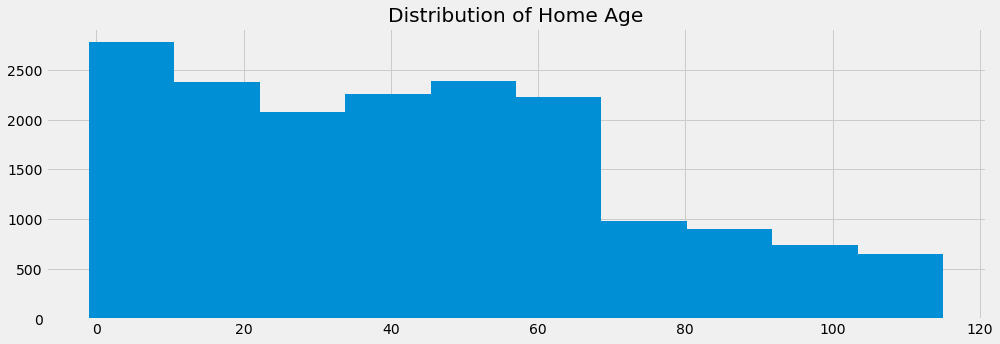

In [633]:
#create new column
df_scrub['home_age'] = df_scrub['yr_sold'] - df_scrub['yr_built']
#plot distribution
fig, ax = plt.subplots(figsize=(15,5))
df_scrub['home_age'].hist(ax=ax);
ax.set_title('Distribution of Home Age');

## Category Columns

I will determine which columns have categorical data and also which columns need to be one-hot encoded in order to be compatible with the model.

In [672]:
#check column names
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'basement',
       'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

In [673]:
#check data types of columns
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15424 entries, 1 to 21596
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            15424 non-null  int64         
 1   date          15424 non-null  datetime64[ns]
 2   price         15424 non-null  float64       
 3   bedrooms      15424 non-null  int64         
 4   bathrooms     15424 non-null  float64       
 5   sqft_living   15424 non-null  int64         
 6   sqft_lot      15424 non-null  int64         
 7   floors        15424 non-null  float64       
 8   waterfront    15424 non-null  float64       
 9   condition     15424 non-null  int64         
 10  grade         15424 non-null  int64         
 11  sqft_above    15424 non-null  int64         
 12  yr_built      15424 non-null  int64         
 13  yr_renovated  15424 non-null  float64       
 14  zipcode       15424 non-null  int64         
 15  lat           15424 non-null  float6

(<AxesSubplot:title={'center':'Distribution of home_age'}>,
 <AxesSubplot:title={'center':'price vs home_age'}, xlabel='home_age', ylabel='price'>,
 count             15,424.0
 mean     43.15676867219917
 std     29.302524447732495
 min                   -1.0
 25%                   18.0
 50%                   39.0
 75%                   62.0
 max                  115.0
 Name: home_age, dtype: float64)

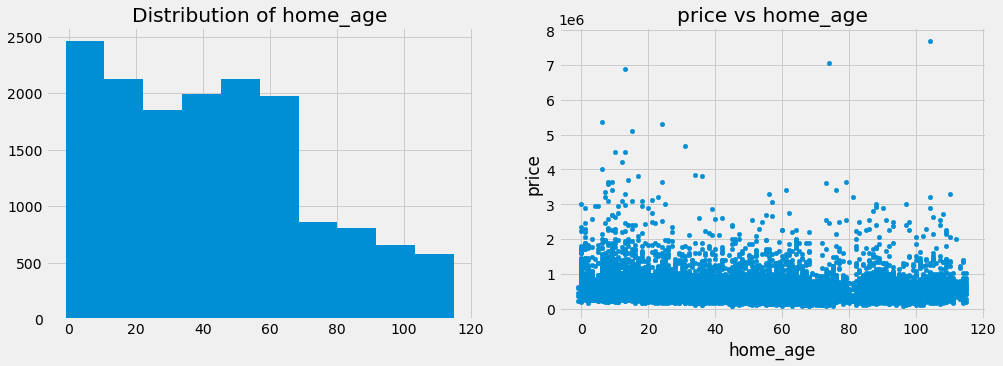

In [717]:
#invvestigate each column
get_plots(df_scrub,'home_age')

> **Observations:**
> - `zipcode` is categorical and needs to be hot-one encoded before putting into the model.

### `zipcode` OHE

In [726]:
#fit the data
cat_zipcode = ['zipcode']
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_scrub[cat_zipcode])

OneHotEncoder(drop='first', sparse=False)

In [727]:
#transform the data
ohe_vars = encoder.transform(df_scrub[cat_zipcode])
ohe_vars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [728]:
#get the features
encoder.get_feature_names(cat_zipcode)

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [729]:
#convert to dataframe
df_cat_zipcode = pd.DataFrame(ohe_vars, columns=encoder.get_feature_names(cat_zipcode), index=df_scrub.index)
df_cat_zipcode

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [730]:
#concat original dataframe to zipcode dataframe
df_scrub = pd.concat([df_scrub.drop('zipcode', axis=1), df_cat_zipcode], axis=1)
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,3,7,2170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,5,7,1050,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,3,8,1680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,3,11,3890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2008000270,2015-01-15,"291,850.0",3,1.5,1060,9711,1.0,0.0,3,7,1060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,"475,000.0",3,2.5,1310,1294,2.0,0.0,3,8,1180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,3,8,1530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,3,8,2310,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,3,7,1020,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Change Data Types

## Null Values

In [634]:
#check for null values
df_scrub.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1915
view               49
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
month_sold          0
renovated           0
yr_sold             0
home_age            0
dtype: int64

### Waterfront Column

In [635]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)

0.0    15357
nan     1915
1.0      117
Name: waterfront, dtype: int64

> **ACTION: I will drop the rows where `waterfront` has a null value**

In [636]:
#drop rows with null values in the waterfront column
df_scrub.dropna(subset=['waterfront'], inplace=True)
df_scrub['waterfront'].isna().sum()

0

In [637]:
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 15474 many rows.


## Duplicates

### Duplicates for `id`

In [638]:
#check for duplicates
duplicate_id = df_scrub.loc[df_scrub.duplicated(subset='id', keep=False) == True].sort_values('id').head(50)
duplicate_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
11421,109200390,2014-08-20,"245,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,...,1980,0.0,98023,47.2977,-122.367,1830,6956,0,8,0,2014,34
11422,109200390,2014-10-20,"250,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,...,1980,0.0,98023,47.2977,-122.367,1830,6956,0,10,0,2014,34
7785,251300110,2014-07-31,"225,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,...,1988,0.0,98003,47.3473,-122.314,1870,8017,0,7,0,2014,26
7786,251300110,2015-01-14,"358,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,...,1988,0.0,98003,47.3473,-122.314,1870,8017,0,1,0,2015,27
9225,302000375,2014-08-14,"169,100.0",3,2.0,1050,18304,1.0,0.0,0.0,4,7,...,1953,0.0,98001,47.3206,-122.26899999999999,1690,15675,0,8,0,2014,61
9226,302000375,2015-05-06,"250,000.0",3,2.0,1050,18304,1.0,0.0,0.0,4,7,...,1953,0.0,98001,47.3206,-122.26899999999999,1690,15675,0,5,0,2015,62
7171,526059224,2014-09-23,"260,000.0",4,1.75,1650,7276,1.0,0.0,0.0,3,7,...,1977,0.0,98011,47.7721,-122.206,1840,8550,1,9,0,2014,37
7172,526059224,2015-02-06,"470,000.0",4,1.75,1650,7276,1.0,0.0,0.0,3,7,...,1977,0.0,98011,47.7721,-122.206,1840,8550,1,2,0,2015,38
17367,641900050,2014-08-19,"335,000.0",4,2.25,2160,8817,1.0,0.0,0.0,3,7,...,1965,0.0,98133,47.7595,-122.35600000000001,1880,8817,1,8,0,2014,49
17368,641900050,2015-02-06,"499,950.0",4,2.25,2160,8817,1.0,0.0,0.0,3,7,...,1965,0.0,98133,47.7595,-122.35600000000001,1880,8817,1,2,0,2015,50


In [639]:
#check duplicates
df_scrub.loc[df_scrub['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
313,4139480200,2014-06-18,"1,380,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,...,1997,0.0,98006,47.5503,-122.102,3860,11244,1,6,0,2014,17
314,4139480200,2014-12-09,"1,400,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,...,1997,0.0,98006,47.5503,-122.102,3860,11244,1,12,0,2014,17


> **Duplicates in the `id` column seem to represent multiple sales of the same house. I will remove them because they aren't many and I am not sure how they will impact the model's prediction.**

In [640]:
#remove duplicates
df_scrub.drop(duplicate_id.index, inplace=True)

## Column Drop

In [641]:
#look at columns
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'month_sold',
       'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### The `view` Column

In [642]:
#look at view column
df_scrub['view'].value_counts()

0.0    13897
2.0      666
3.0      339
1.0      242
4.0      235
Name: view, dtype: int64

> **ACTION: The `view` column does not seem to be important to keep going forward.**

In [643]:
#drop the view column
df_scrub.drop(columns='view', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement', 'month_sold', 'renovated',
       'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_basement` Column

The `sqft_basement` column can be eliminated now that I have a column which represents whether or not a house has a basement.

In [644]:
#drop the sqft_basement column
df_scrub.drop(columns='sqft_basement', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'basement', 'month_sold', 'renovated', 'yr_sold',
       'home_age'],
      dtype='object')

### The `sqft_living15` and `sqft_lot15` Columns

The `sqft_living15` and `sqft_lot15` columns do not seem to be relevant for predicting home listing prices. I will remove these.

In [645]:
df_scrub.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'basement',
       'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

# Explore

I will now explore the dataset after initial scrubbing. I will investigate distributions, outliers and take action in order to prepare the data for modeling.

## Distributions and Descriptive Statistics

(<AxesSubplot:title={'center':'Distribution of floors'}>,
 count            15,424.0
 mean    1.495591286307054
 std     0.538909460934581
 min                   1.0
 25%                   1.0
 50%                   1.5
 75%                   2.0
 max                   3.5
 Name: floors, dtype: float64)

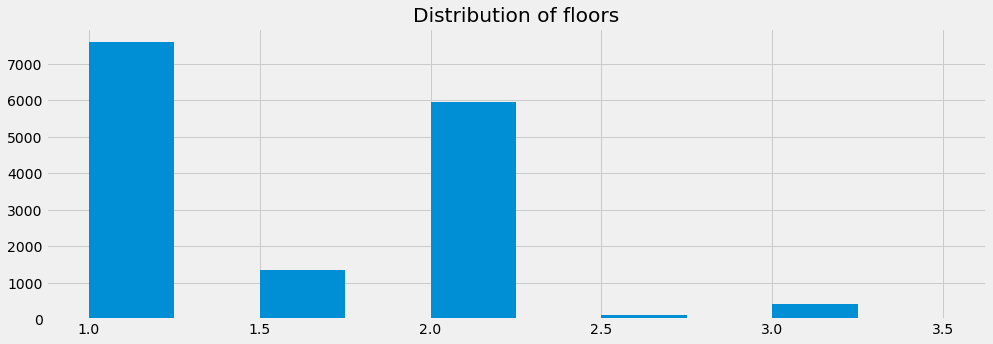

In [646]:
get_hist(df_scrub,'floors')

In [647]:
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,"1,991.0",98125,47.721000000000004,-122.319,1,12,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.39299999999999,1,12,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,0,2,0,2015,28
5,7237550310,2014-05-12,"1,230,000.0",4,4.5,5420,101930,1.0,0.0,3,11,3890,2001,0.0,98053,47.6561,-122.005,1,5,0,2014,13
7,2008000270,2015-01-15,"291,850.0",3,1.5,1060,9711,1.0,0.0,3,7,1060,1963,0.0,98198,47.4095,-122.315,0,1,0,2015,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2015-02-19,"475,000.0",3,2.5,1310,1294,2.0,0.0,3,8,1180,2008,0.0,98116,47.5773,-122.40899999999999,1,2,0,2015,7
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,3,8,1530,2009,0.0,98103,47.6993,-122.346,0,5,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,3,8,2310,2014,0.0,98146,47.5107,-122.36200000000001,0,2,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,3,7,1020,2009,0.0,98144,47.5944,-122.29899999999999,0,6,0,2014,5


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''